<img style="float: right; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="350px" height="180px" /> 


# <font color= 'navy'> EDA - Desempleo en USA -  Parte II</font>
### <font color= #2E9AFE> Ética para la Ciencia de Datos</font>


- <Strong> José Manuel Haces López - 734759</Strong>


- <Strong> Claudia Celeste Castillejos Jáuregui - 735868 </Strong>


- <Strong> Marcela Quintero Perez - 717644 </Strong>


- <Strong> Pablo Ivan Orosco Beltran - 723252 </Strong>


<Strong> Fecha </Strong>:  Mayo 2023.

In [1]:
# Preprocesamiento
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Modelos
import keras
import xgboost as xgb
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.cluster import AffinityPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# Configuración
warnings.filterwarnings('ignore')

##  Carga de Datos

In [2]:
# Cargando el conjunto de datos
df = pd.read_csv('./Data/Procesado/Nonvoters_Dataset.csv')
# Quitamos la columna de IDs
df = df.drop(['RespId'], axis=1)
# Renombramos columnas
df = df.rename(columns={'educ': 'Educacion', 'race': 'Raza', 'gender': 'Genero', 'income_cat': 'Ingresos', 'voter_category': 'Categoria_Votante'})
df.head()

,Educacion,Raza,Genero,Ingresos,Categoria_Votante
0,College,White,Female,$75-125k,always
1,College,White,Female,$125k or more,always
2,College,White,Male,$125k or more,sporadic
3,Some college,Black,Female,$40-75k,sporadic
4,High school or less,White,Male,$40-75k,always


## Procesamiento de los datos

In [3]:
# Haciendo que la categoría de votante sea nuestro target y numerizándola
df['Categoria_Votante'] = df['Categoria_Votante'].replace({'always': 1, 'sporadic': 1, 'rarely/never': 0})
df.head()

,Educacion,Raza,Genero,Ingresos,Categoria_Votante
0,College,White,Female,$75-125k,1
1,College,White,Female,$125k or more,1
2,College,White,Male,$125k or more,1
3,Some college,Black,Female,$40-75k,1
4,High school or less,White,Male,$40-75k,1


In [4]:
# Creando dummines para las variables categóricas
df = pd.get_dummies(df, columns=['Educacion', 'Raza', 'Genero', 'Ingresos'])
df.head()

,Categoria_Votante,Educacion_College,Educacion_High school or less,Educacion_Some college,Raza_Black,Raza_Hispanic,Raza_Other/Mixed,Raza_White,Genero_Female,Genero_Male,Ingresos_$125k or more,Ingresos_$40-75k,Ingresos_$75-125k,Ingresos_Less than $40k
0,1,1,0,0,0,0,0,1,1,0,0,0,1,0
1,1,1,0,0,0,0,0,1,1,0,1,0,0,0
2,1,1,0,0,0,0,0,1,0,1,1,0,0,0
3,1,0,0,1,1,0,0,0,1,0,0,1,0,0
4,1,0,1,0,0,0,0,1,0,1,0,1,0,0


## Valanceo de Clases

<Axes: xlabel='Categoria_Votante', ylabel='count'>

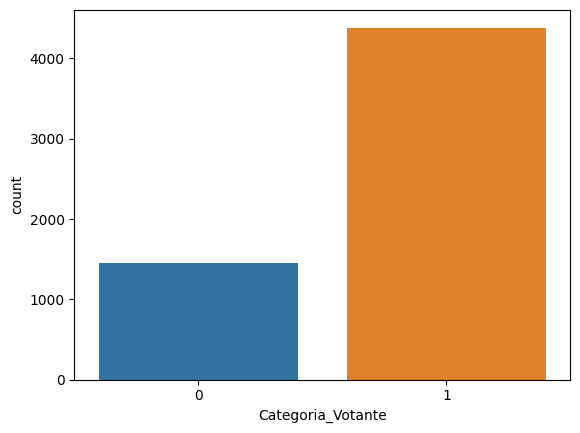

In [5]:
# Plot de la variable target para ver el tamaño de las clases
sns.countplot(x='Categoria_Votante', data=df)

- Tenemos datos invalanceados, usaremos SMOTE para poder balancearlos.
    - SMOTE: Synthetic Minority Oversampling Technique es una técnica de sobremuestreo que genera muestras sintéticas de la clase minoritaria. Se basa en el algoritmo KNN (K-Nearest Neighbors) que se utiliza para crear instancias sintéticas de la clase minoritaria. Se selecciona un punto de datos de la clase minoritaria y se calculan los K vecinos más cercanos para este punto. Los puntos de datos sintéticos se crean entre el punto de datos seleccionado y sus vecinos.

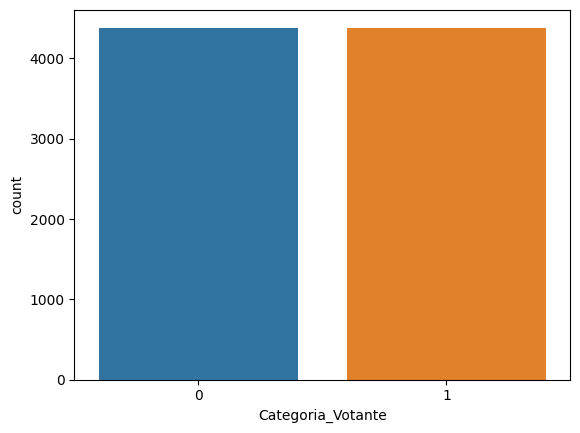

In [6]:
# Aplicando el SMOTE para balancear el conjunto de datos
smote = SMOTE(random_state=0)
X = df.drop(['Categoria_Votante'], axis=1)
y = df['Categoria_Votante']
X, y = smote.fit_resample(X, y)

# Plot de la variable target
sns.countplot(x=y)
plt.show()

In [7]:
# Dividiendo el conjunto de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Convirtiendo los datos a tensores
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Agregando una dimensión a los datos de y
y_train = tf.expand_dims(y_train, axis=1)
y_test = tf.expand_dims(y_test, axis=1)

# Mostremos la forma de los datos
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (7016, 13)
X_test shape: (1754, 13)
y_train shape: (7016, 1)
y_test shape: (1754, 1)


## Modelado con Variables Protegidas

### XGBoost

Accuracy: 0.6174


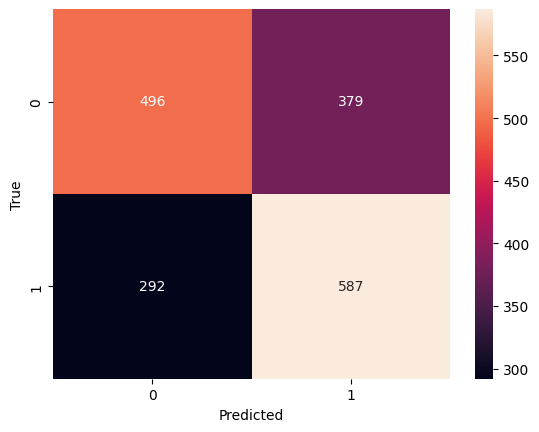

In [8]:
# Creando el modelo de XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# Entrenando el modelo
xgb_model.fit(X_train, y_train)

# Haciendo predicciones
y_pred = xgb_model.predict(X_test)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Regresión Logística

Accuracy: 0.6083


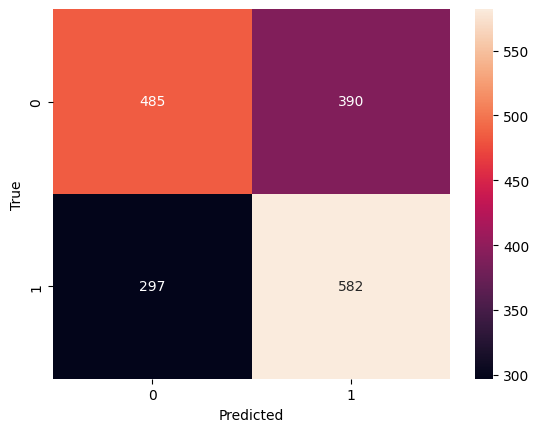

In [9]:
# Creando el modelo de Regresión Logística
lr_model = LogisticRegression()
# Entrenando el modelo
lr_model.fit(X_train, y_train)

# Haciendo predicciones
y_pred = lr_model.predict(X_test)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest

Accuracy: 0.6157


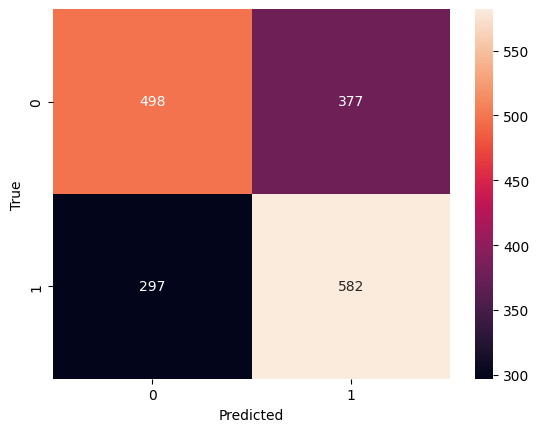

In [10]:
# Creando el modelo de Random Forest
rf_model = RandomForestClassifier()
# Entrenando el modelo
rf_model.fit(X_train, y_train)

# Haciendo predicciones
y_pred = rf_model.predict(X_test)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MLP

55/55 [==============================] - 0s 2ms/step
Accuracy: 0.6152


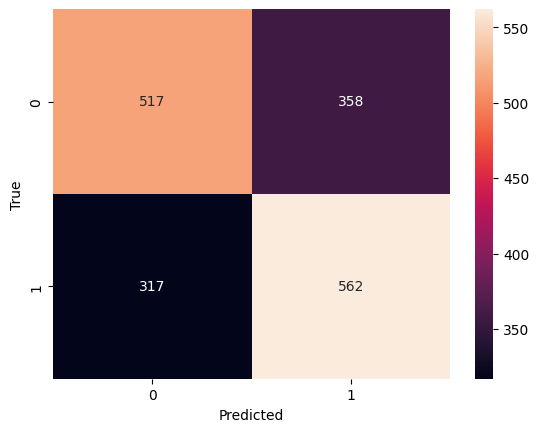

In [11]:
# Creando el modelo de Red Neuronal
nn_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilando el modelo
nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

# Entrenando el modelo
nn_model.fit(X_train, 
             y_train,
             validation_split=0.2,
             epochs=50, 
             batch_size=32,
             verbose=0)

# Haciendo predicciones
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Modelado sin Variables Protegidas

In [12]:
# Cargando el conjunto de datos
df = pd.read_csv('./Data/Procesado/Nonvoters_Dataset.csv')
# Quitamos la columna de IDs
df = df.drop(['RespId'], axis=1)
# Renombramos columnas
df = df.rename(columns={'educ': 'Educacion', 'race': 'Raza', 'gender': 'Genero', 'income_cat': 'Ingresos', 'voter_category': 'Categoria_Votante'})

# Reemplazamos valores
df['Categoria_Votante'] = df['Categoria_Votante'].replace({'always': 1, 'sporadic': 1, 'rarely/never': 0})

# Creando dummines para las variables categóricas
df = pd.get_dummies(df.drop(columns=['Raza', 'Genero']), columns=['Educacion', 'Ingresos'])


# Aplicando el SMOTE para balancear el conjunto de datos
smote = SMOTE(random_state=0)
X = df.drop(['Categoria_Votante'], axis=1)
y = df['Categoria_Votante']
X, y = smote.fit_resample(X, y)

# Dividiendo el conjunto de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Convirtiendo los datos a tensores
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Agregando una dimensión a los datos de y
y_train = tf.expand_dims(y_train, axis=1)
y_test = tf.expand_dims(y_test, axis=1)

# Mostremos la forma de los datos
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (7016, 7)
X_test shape: (1754, 7)
y_train shape: (7016, 1)
y_test shape: (1754, 1)


### XGBoost

Accuracy: 0.6055


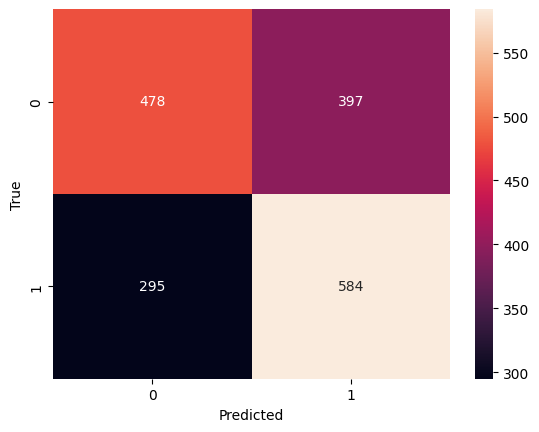

In [13]:
# Creando el modelo de XGBoost
xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# Entrenando el modelo
xgb_model.fit(X_train, y_train)

# Haciendo predicciones
y_pred = xgb_model.predict(X_test)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Regresión Logística]

Accuracy: 0.6015


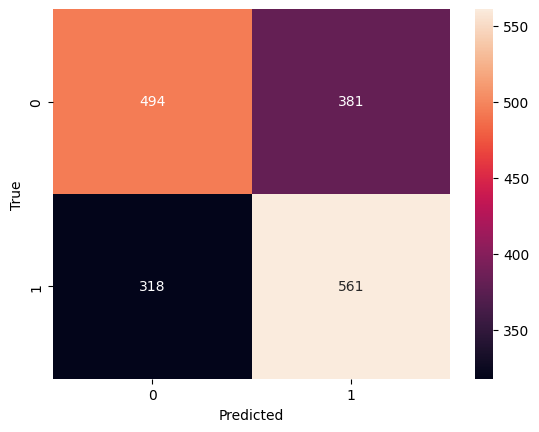

In [14]:
# Creando el modelo de Regresión Logística
lr_model = LogisticRegression()
# Entrenando el modelo
lr_model.fit(X_train, y_train)

# Haciendo predicciones
y_pred = lr_model.predict(X_test)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest

Accuracy: 0.6055


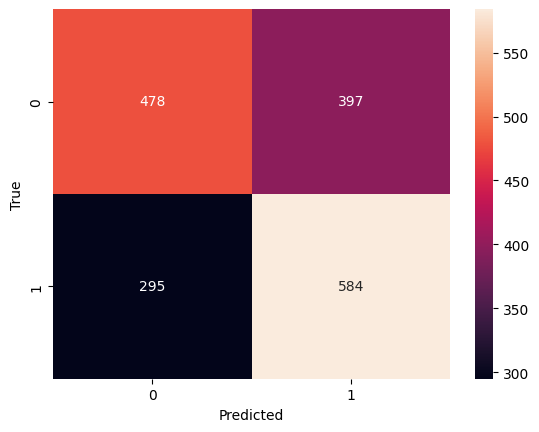

In [15]:
# Creando el modelo de Random Forest
rf_model = RandomForestClassifier()
# Entrenando el modelo
rf_model.fit(X_train, y_train)

# Haciendo predicciones
y_pred = rf_model.predict(X_test)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### MLP

55/55 [==============================] - 0s 2ms/step
Accuracy: 0.6055


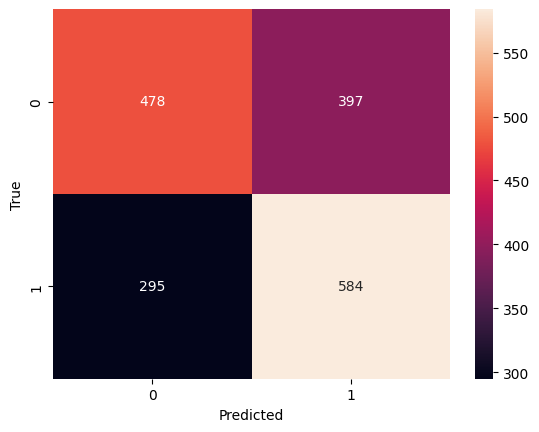

In [16]:
# Creando el modelo de Red Neuronal
nn_model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compilando el modelo
nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Entrenando el modelo
nn_model.fit(X_train,
            y_train,
            validation_split=0.2,
            epochs=50,
            batch_size=32,
            verbose=0)

# Haciendo predicciones
y_pred = nn_model.predict(X_test)
y_pred = np.round(y_pred)

# Evaluando el modelo
print('Accuracy:', np.round(accuracy_score(y_test, y_pred), decimals=4))

# Obteniendo la matriz de confusión y ploteando con seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()